In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 1. Generate Data
# Prepare sine wave data
x = np.linspace(0, 100, 10000)
y = np.sin(x)

# Function to create sequences
def create_sequences(data, seq_len):
    xs = []
    ys = []
    for i in range(len(data) - seq_len):
        xs.append(data[i:(i + seq_len)])
        ys.append(data[i + seq_len])
    return np.array(xs), np.array(ys)

In [6]:
seq_length = 5

X, y = create_sequences(y, seq_length)

# Reshape X for RNN input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
# Split the data into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# 2. Build the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = RNNModel(input_size=1, hidden_size=50, output_size=1)

# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 3. Train the Model
num_epochs = 5
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        targets = targets.view(-1, 1)  # Reshape targets to match the shape of outputs
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0257
Epoch [2/5], Loss: 0.0206
Epoch [3/5], Loss: 0.0112
Epoch [4/5], Loss: 0.0088
Epoch [5/5], Loss: 0.0041


In [11]:
# Test the model on unseen data
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    y_test = y_test.view(-1, 1)  # Reshape y_test to match the shape of predictions
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0099


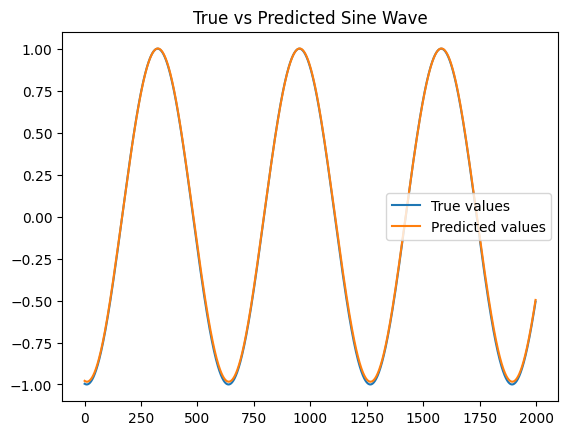

In [9]:
# Plot the predicted values vs the true values
plt.plot(y_test, label='True values')
plt.plot(predictions, label='Predicted values')
plt.legend()
plt.title('True vs Predicted Sine Wave')
plt.show()